In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import pytorch_lightning as pl
from torch import nn
import math
from itertools import product

import os, sys
sys.path.append(os.path.join(os.getcwd(), '../symlie'))
sys.path.append(os.path.join(os.getcwd(), '../sympde/viz'))
sys.path.append(os.path.join(os.getcwd(), '../sympde/misc'))

from run import parse_options, main

from model.networks.linear import MyLinear
from model.networks.convs import MyConv1d
from model.networks.mlp import MLP

from general_plots import imshows, plot_vals, simple_imshow
from equiv import assert_equiv

plt.rcParams['image.cmap'] = 'viridis'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ImportError: cannot import name 'MyLinear' from 'model.networks.linear' (/Users/elias/Documenten MBA/Studie/Thesis/SymPDE/notebooks_symlie/../symlie/model/networks/linear.py)

In [184]:
seeds = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
transform_types = ['space_translation', 'none']
do_return = False

seeds = [9]
transform_types = ['none']
do_return = True

for transform_type in transform_types:
    for seed in seeds:

        args = parse_options(notebook=True)
        args.train = True
        args.persistent_workers = True

        args.do_return = do_return

        args.seed = seed
        args.transform_type = transform_type

        args.version = 'dev3'

        # args.linearmodules = ['MyLinear', 'MyLinear']
        args.linearmodules = ['MyLinear', 'nn.Linear']
        args.bias = False

        args.dim = 3
        # args.n_splits = [100, 100, 100]

        # Training
        model, trainer, datamodule = main(args)

Seed set to 9
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs




###	Version:  dev3 	###
###	Name:  symlie_datamnist_netMLP_transformnone_seed9 	###




/Users/elias/anaconda3/envs/sympde/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/elias/anaconda3/envs/sympde/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


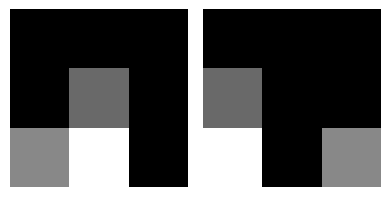

In [185]:
dataset, dataset_aug = [dataloader.dataset for dataloader in datamodule.test_dataloader()]
imgs, labels         = next(iter(datamodule.test_dataloader()[0]))
imgs_aug, labels_aug = next(iter(datamodule.test_dataloader()[1]))

i = 1
x, y = dataset[i]
x_aug, y_aug = dataset_aug[i]

imshows([x, x_aug], axis_off = True, imshow_kwargs={'cmap': 'gray'})

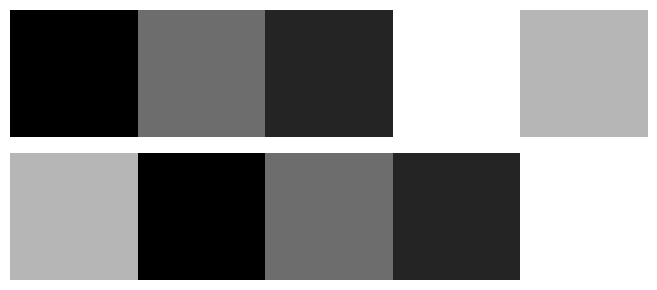

In [186]:
x = torch.tensor([[0.1, 0.4, 0.2, 0.8, 0.6]])
x_aug = torch.roll(x, shifts = 1, dims = 1)
space_len = len(x[0])
imshows([x, x_aug], axis_off = True, imshow_kwargs={'cmap': 'gray'}, rows = False)


In [189]:
conv = nn.Conv1d(
    in_channels  = 1, 
    out_channels = 1,
    kernel_size  = 3,
    padding = 1,
    bias = False,
    padding_mode = 'circular',
)

In [190]:
# conv = MyConv1d(
conv = nn.Conv1d(
    in_channels  = 1, 
    out_channels = 1,
    kernel_size  = 3,
    padding = 1,
    bias = False,
    padding_mode = 'circular',
)

out_conv = conv(x.unsqueeze(0)).squeeze(0)
out_conv


tensor([[-0.1115,  0.0463, -0.3040, -0.0110,  0.2388]],
       grad_fn=<SqueezeBackward1>)

In [200]:
out_conv

tensor([[-0.1115,  0.0463, -0.3040, -0.0110,  0.2388]],
       grad_fn=<SqueezeBackward1>)

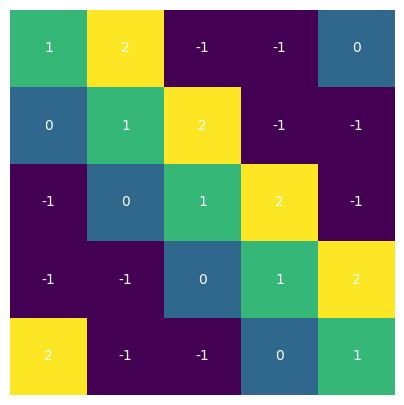

In [199]:
linear = MyLinear(
    in_features = space_len,
    out_features = space_len,
    bias = False,
    transform_type = 'convolution',
)

linear.weight.data = torch.full_like(linear.weight.data, 0)
linear.weight.data.flatten()[:3] = conv.weight.squeeze()

p1 = linear.w_index
simple_imshow(p1, l = 1., precision = 0)

o1 = linear(x)
assert torch.allclose(o1, out_conv)